In [1]:
%matplotlib inline
#from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl
import pickle as pkl

In [3]:
def readDat(files, path, time_zone, from_wrf = True):
    """
    Read time series csv files for each station code from a specific path
    
    Parameters
    ----------
    files : str list
        name of csv files
    path  : str
        path location
    time_zone : str
        for instance 'America/Sao_Paulo'
    
    Returns
    -------
    Pandas DataFrame
    """
    Data = pd.DataFrame()
    
    if from_wrf:
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
        Data.loc[:,'local_date']=Data['date'].dt.tz_convert(time_zone)
        return Data
    
    else: # observations
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
        Data.rename(columns={'date':'local_date'}, inplace = True)
        Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
        return Data

def subplots_rcp(df,pol,ylabel,xlabel,suffixes,legend, legend_size, hspace,
                 size, n_yticks, n_xticks,filename,alpha,lw,markersize,labelsize, by):
    """
    Return lineplot subplots by station only completed data to be compared.
    
    Parameters
    ----------
    df       : pandas DataFrame with datetime as index
               time series with colnames as station and meteorological and air quality parameters
    pol      : str
               air quality parameter, for instance, pol = 'o3'
    ylabel   : str
    xlabel   : str
    suffixes : list of two strings, for instance suffixes = ['_rcp45','_rcp85']
    legend   : list of three strings
    leg_size : int
    hspace   : float
    size     : tuple, default size = (6,8)
    n_yticks : int
               Number of yaxis labels
    n_xticks : int
               Interval number of xaxis labels               
    path     : str
               path location where the figure will be located
    name     : str
               suffix name of figure
    alpha    : float between 0 and 1. Default 0.7
    lw       : int
    markersize : int
    labelsize : int
    by       : str
               subplots by specific name based column names
    
    Returns
    -------
    Figure exported as pdf plot in a specific path
    
    """
    df_1 = df[[by,pol,pol+suffixes[0],pol+suffixes[1]]].dropna()
    locs = list(df_1.sort_values(by=by,ascending=True)[by].unique()) 
    
    fig, ax = plt.subplots(df_1[by].nunique(),
                           figsize=size, 
                           sharex=True, sharey=True,
                           gridspec_kw={'hspace':hspace})
    for i in range(df_1[by].nunique()):
        df_1.loc[df_1[by] == locs[i]][pol].\
        plot(ax=ax[i],color='g', marker='.',linestyle='none',
             markersize=markersize, label=legend[0])
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[0]].\
        plot(ax=ax[i],color='c', linestyle='-',lw=lw, alpha=alpha, label=legend[1]) #86B2D6
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[1]].\
        plot(ax=ax[i],color='#D22523', linestyle='-',lw=lw, alpha=alpha, label=legend[2])
        ax[0].xaxis.set_major_formatter(md.DateFormatter('%d'))
        ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,n_xticks)))
        ax[0].xaxis.set_minor_locator(md.MonthLocator())
        ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n%b'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[i].tick_params(axis='both', which='minor', labelsize=labelsize)
        ax[i].tick_params(axis='both', labelsize=labelsize)
        ax[i].set_xlabel(xlabel)
        ax[2].set_ylabel(ylabel)
        ax[i].set_title(locs[i],size=8, loc='left')
        if i == len(df_1[by].unique())-1:
            ax[i].legend(fontsize=legend_size)
    fig.savefig(filename+'_subplot_'+pol+'.pdf',bbox_inches='tight', facecolor='w')

# Changes in Surface O$_3$

Two emission scenarios RCP4.5 and RCP8.5 as meteorological initial and boundary conditions in the WRF-Chem model was obtained from NCAR CESM Global Bias-Corrected (ds316.1). These datasets have one degree of spatial resolution every six hours. Emission files entered to WRF-Chem were the same information used to simulate 2018. So, only meteorology IC/BC used are different of the modelling done for the control-case simulation (2018). WRF-Chem results correspond to all hours of September 2030 and covers the same stations analyzed in modelling results for September 2018.

In [4]:
stations = pd.read_csv('../1_ObsData/stations.csv')
not_stations = ['Santos',
                'Santos-Ponta da Praia',
                'Cubatão-Centro',
                'Cubatão-Vale do Mogi',
                'Cubatão-V.Parisi']
stations = stations.loc[(~stations.name.isin(not_stations)) & \
                        (stations.domain =='d02')]\
            .drop('domain', axis=1).sort_values(by='code')
stations.index =stations.code
stations.head()

,name,lat,lon,code,type,abb
code,,,,,,
0,IAG,-23.651200,-46.622400,0,Forest preservation,IAG
63,Santana,-23.505993,-46.628960,63,Urban,Stna
64,Santo Amaro,-23.654977,-46.709998,64,Urban,SAm
65,Mauá,-23.668549,-46.466000,65,Urban,Maua
67,Sorocaba,-23.502427,-47.479030,67,Regional urban,Srcb


We import data for modelling simulations corresponds to September, 2018 and emission scenarios RCP4.5 and RCP8.5 for years 2030 and 2050. According to suggestions of Ritter (2013), modelling run was set-up with reinitialization and one day of spin-up.

In [5]:
# Import and modelling results
filename = 'data/Mod_data_oct.pkl' # as pandas DataFrame

if os.path.exists(filename) is False:
    # Sep. 2018 (Control-case)
    Dir = '../3_Results/Y2018/wrfout_exp10/oct18/' #SEP18/wrfout_exp10/
    f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')

    sep18 = readDat(f18, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    sep18.rename(columns={'name':'station'})
    sep18 = sep18[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    sep18['nox'] = sep18.no+sep18.no2
    sep18['Mday']= sep18.local_date.dt.strftime('%b-%d-%H')
  
    # Sep. 2030 (RCP4.5):
    Dir = '../3_Results/RCP4.5/wrfout_exp10/oct30/'
    f30_rcp45 = fnmatch.filter(os.listdir(Dir), '*rcp45*')
    rcp45_30  = readDat(f30_rcp45, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    rcp45_30.rename(columns={'name':'station'})
    rcp45_30 = rcp45_30[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    rcp45_30['nox'] = rcp45_30.no+rcp45_30.no2
    rcp45_30['Mday']= rcp45_30.local_date.dt.strftime('%b-%d-%H')
    
    # Sep. 2030 (RCP8.5):
    Dir = '../3_Results/RCP8.5/wrfout_exp10/oct30/'
    f30_rcp85 = fnmatch.filter(os.listdir(Dir), '*rcp85*')
    rcp85_30  = readDat(f30_rcp85, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    rcp85_30.rename(columns={'name':'station'})
    rcp85_30 = rcp85_30[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    rcp85_30['nox'] = rcp85_30.no+rcp85_30.no2
    rcp85_30['Mday']= rcp85_30.local_date.dt.strftime('%b-%d-%H')
    
    # Merge data
    by = ['Mday','station','code','type']
    Mod = rcp45_30.merge(rcp85_30,on=by,suffixes=('_rcp45', '_rcp85')).merge(sep18, on=by)
        
          # to pickle
    Mod.to_pickle(filename)
else:
    Mod = pd.read_pickle(filename)
    #Obs_dic = pkl.load(open(fname_1, "rb"))
    #Mod_dic = pkl.load(open(fname_2, "rb"))




In [6]:
Mod

,local_date_rcp45,code,station,type,tc_rcp45,rh_rcp45,ws_rcp45,wd_rcp45,o3_rcp45,no_rcp45,...,local_date,tc,rh,ws,wd,o3,no,no2,co,nox
0,2030-09-30 21:00:00-03:00,276,Campinas-Taquaral,Regional urban,26.6396,47.1997,5.56546,114.113,98.8277,0.06832,...,2018-09-30 21:00:00-03:00,22.800049,82.316345,0.846548,103.341560,26.147875,1.494905,51.043180,0.257408,52.538085
1,2030-09-30 22:00:00-03:00,276,Campinas-Taquaral,Regional urban,24.9873,53.9153,5.26635,117.042,89.4314,0.0795468,...,2018-09-30 22:00:00-03:00,22.628052,81.292820,0.715257,67.186490,33.469875,0.828933,43.804840,0.236108,44.633773
2,2030-09-30 23:00:00-03:00,276,Campinas-Taquaral,Regional urban,24.3467,53.4391,5.53588,114.947,92.2326,0.0667467,...,2018-09-30 23:00:00-03:00,22.546356,78.630840,1.263128,50.897470,40.478058,0.535005,38.090210,0.200392,38.625215
3,2030-10-01 00:00:00-03:00,276,Campinas-Taquaral,Regional urban,23.6813,52.9342,5.09033,112.937,92.0432,0.0645473,...,2018-10-01 00:00:00-03:00,22.188782,79.545730,1.254595,37.074844,42.136913,0.446720,35.295883,0.183006,35.742603
4,2030-10-01 01:00:00-03:00,276,Campinas-Taquaral,Regional urban,23.1646,54.34,5.05259,111.899,91.1944,0.0629766,...,2018-10-01 01:00:00-03:00,22.240814,76.987800,1.728764,32.017480,50.953514,0.294762,23.218931,0.145236,23.513693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42403,2030-10-31 16:00:00-03:00,118,Guarulhos,Urban,21.2949,71.7283,5.83975,125.455,42.8267,3.05856,...,2018-10-31 16:00:00-03:00,30.034150,46.556812,2.669371,279.935200,104.199580,2.485126,19.714422,0.175072,22.199548
42404,2030-10-31 17:00:00-03:00,118,Guarulhos,Urban,20.549,74.7556,6.12216,135.998,34.8614,3.10655,...,2018-10-31 17:00:00-03:00,27.969513,53.412210,2.400488,139.484530,108.735640,1.861195,29.213182,0.179236,31.074377
42405,2030-10-31 18:00:00-03:00,118,Guarulhos,Urban,19.4633,78.255,5.53903,131.747,30.8165,2.55587,...,2018-10-31 18:00:00-03:00,26.780334,58.910072,4.144518,177.818680,112.307670,0.916365,56.843170,0.340410,57.759535
42406,2030-10-31 19:00:00-03:00,118,Guarulhos,Urban,18.3866,85.7517,5.27105,129.691,25.8617,2.42004,...,2018-10-31 19:00:00-03:00,25.133972,64.497960,2.260399,165.607380,102.675606,0.135169,60.732540,0.328297,60.867709


In [7]:
# Rolling 8 hour mean
o3 = Mod[['local_date','station','type', 'o3','o3_rcp45','o3_rcp85']].set_index('local_date')
o3['o3_rcp45'] = o3['o3_rcp45'].astype(float)
o3['o3_rcp85'] = o3['o3_rcp85'].astype(float)
roll_o3 = {}
rollo3 = pd.DataFrame()
for i in o3.station.unique():
    roll_o3[i] = (o3[o3.station == i].rolling(window=8).mean()[['o3','o3_rcp45','o3_rcp85']])
    roll_o3[i]['station'] = i
    roll_o3[i]['type'] = (o3[o3.station == i].type)
    df = roll_o3[i]
    rollo3 = pd.concat([rollo3,df])
    rollo3['day'] = rollo3.index.day
    MDA8 = rollo3.groupby(['day','station','type']).max().reset_index().dropna()
    
types = list(MDA8.sort_values(by='type',ascending=True).type.unique())

In [8]:
o3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42408 entries, 2018-09-30 21:00:00-03:00 to 2018-10-31 20:00:00-03:00
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   station   42408 non-null  object 
 1   type      42408 non-null  object 
 2   o3        42408 non-null  float64
 3   o3_rcp45  42408 non-null  float64
 4   o3_rcp85  42408 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.9+ MB


In [9]:
Mod = Mod[Mod.local_date > '2018-09-30 23:00:00']
parameters = ['tc_rcp45', 'rh_rcp45','ws_rcp45', 'wd_rcp45', 'o3_rcp45', 'no_rcp45', 'no2_rcp45', 'co_rcp45',
       'nox_rcp45', 'tc_rcp85', 'rh_rcp85', 'ws_rcp85', 'wd_rcp85', 'o3_rcp85', 'no_rcp85', 'no2_rcp85', 'co_rcp85',
       'nox_rcp85']
for p in parameters:
    Mod[p] = Mod[p].astype(float)
Mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42237 entries, 3 to 42407
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype                            
---  ------            --------------  -----                            
 0   local_date_rcp45  42237 non-null  datetime64[ns, America/Sao_Paulo]
 1   code              42237 non-null  object                           
 2   station           42237 non-null  object                           
 3   type              42237 non-null  object                           
 4   tc_rcp45          42237 non-null  float64                          
 5   rh_rcp45          42237 non-null  float64                          
 6   ws_rcp45          42237 non-null  float64                          
 7   wd_rcp45          42237 non-null  float64                          
 8   o3_rcp45          42237 non-null  float64                          
 9   no_rcp45          42237 non-null  float64                          
 10  no2_rcp45 

<ipython-input-9-104efe312273>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mod[p] = Mod[p].astype(float)


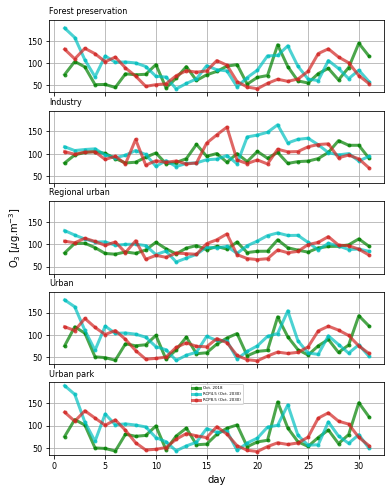

In [21]:
fig, ax = plt.subplots(len(types),
                       figsize=(6,8),
                       sharey=True,
                       sharex=True,
                       gridspec_kw={'hspace':0.25})
for i in range(len(types)):
    MDA8.loc[MDA8.type ==types[i]].groupby(['type','day'])\
    .mean().reset_index().set_index('day')\
    .plot(ax=ax[i], legend=False, grid=True, fontsize=8,
          color=['g','c','#D22523'], lw=3, marker='.', alpha=.7)
    ax[i].set_title(types[i],size=8, loc='left')
    ax[2].set_ylabel('O$_3$ [$\mu$g.m$^{-3}$]')
    if i == len(types)-1:
        ax[i].legend(['Oct. 2018','RCP4.5 (Oct. 2030)','RCP8.5 (Oct. 2030)'],fontsize=4)
fig.savefig('../4_Draft_Report/Dissertation/fig/MDA8_type_rcps_oct18.pdf',bbox_inches='tight', facecolor='w')

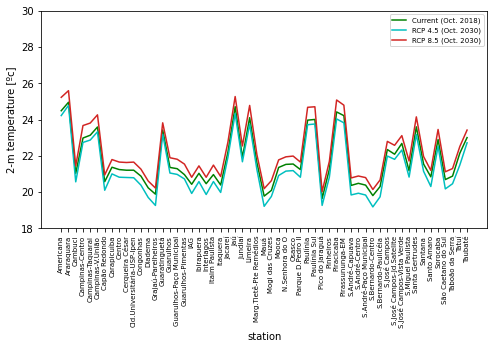

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
plot_1 = Mod.groupby(['station']).mean()[['tc','tc_rcp45','tc_rcp85']]
plot_1.plot(rot=90,color=['g','c','#D22523'], ax=ax)
ax.legend(['Current (Oct. 2018)','RCP 4.5 (Oct. 2030)','RCP 8.5 (Oct. 2030)'], fontsize=7)
ax.set_ylabel('2-m temperature [ºc]')
xtick_labels = list(plot_1.index)
ax.set_xticks(range(len(xtick_labels)))
ax.set_ylim(18,30)
ax.set_xticklabels(xtick_labels, rotation='vertical', fontdict={'fontsize':7})
fig.savefig('../4_Draft_Report/Dissertation/fig/temp_oct.pdf',bbox_inches='tight', facecolor='w')

In [36]:
Mod.groupby(['station']).mean()[['rh','rh_rcp45','rh_rcp85']]

,rh,rh_rcp45,rh_rcp85
station,,,
Americana,66.190773,62.225575,54.414973
Araraquara,68.279402,63.337691,55.211464
Cambuci,75.346028,71.393480,66.938497
Campinas-Centro,69.574895,65.737041,58.173021
Campinas-Taquaral,69.421643,65.838723,58.210607
Campinas-V.União,67.783132,63.657887,56.617529
Capão Redondo,77.666736,73.918445,69.632685
Carapicuíba,73.860181,69.545764,65.192926
Centro,74.437412,70.324491,65.952335


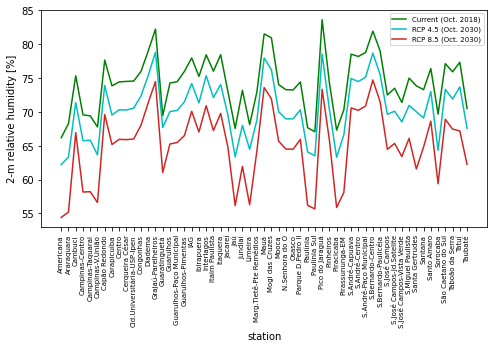

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
plot_1 = Mod.groupby(['station']).mean()[['rh','rh_rcp45','rh_rcp85']]
plot_1.plot(rot=90,color=['g','c','#D22523'], ax=ax)
ax.legend(['Current (Oct. 2018)','RCP 4.5 (Oct. 2030)','RCP 8.5 (Oct. 2030)'], fontsize=7)
ax.set_ylabel('2-m relative humidity [%]')
xtick_labels = list(plot_1.index)
ax.set_xticks(range(len(xtick_labels)))
#ax.set_ylim(18,30)
ax.set_xticklabels(xtick_labels, rotation='vertical', fontdict={'fontsize':7})
fig.savefig('../4_Draft_Report/Dissertation/fig/rh_oct.pdf',bbox_inches='tight', facecolor='w')

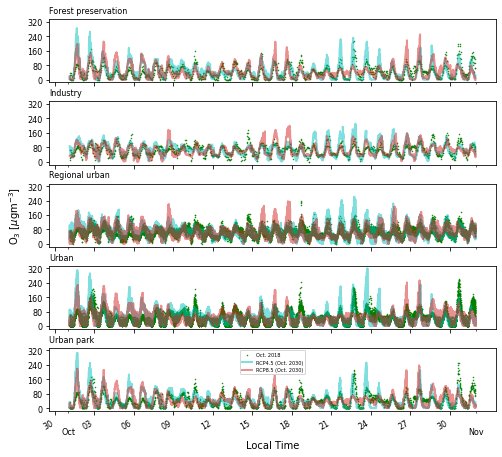

In [12]:
subplots_rcp(Mod.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_rcp45','_rcp85'],
         legend=['Oct. 2018','RCP4.5 (Oct. 2030)','RCP8.5 (Oct. 2030)'],
         legend_size=5,
         size=(8,8),
         hspace=0.3,
         n_yticks=5,
         n_xticks=3,
         filename='../4_Draft_Report/Dissertation/fig/rcp_2030_oct',
         alpha=.5,
         markersize=1,
         lw=2,
         labelsize=8, 
         by='type')

## Spatial Variation 

In [17]:
from mpl_toolkits.basemap import Basemap

In [18]:
o3_mean = MDA8.groupby('station').mean().reset_index().drop('day',axis=1)
o3_mean['lat'] = [stations[stations.name == i].lat.values[0] for i in o3_mean.station]
o3_mean['lon'] = [stations[stations.name == i].lon.values[0] for i in o3_mean.station]
o3_mean


,station,o3,o3_rcp45,o3_rcp85,lat,lon
0,Americana,100.334080,110.743717,104.350602,-22.724253,-47.339549
1,Araraquara,89.345313,93.023086,89.127866,-21.782522,-48.185832
2,Cambuci,77.616725,87.379885,78.364114,-23.567708,-46.612273
3,Campinas-Centro,93.422538,104.932380,94.911468,-22.902525,-47.057211
4,Campinas-Taquaral,94.232848,105.388090,94.693555,-22.874619,-47.058973
5,Campinas-V.União,98.078709,109.762361,101.990554,-22.946728,-47.119281
6,Capão Redondo,81.622891,87.206742,83.497913,-23.668356,-46.780043
7,Carapicuíba,84.471031,92.035029,88.690714,-23.531395,-46.835780
8,Centro,76.280610,87.148523,78.348572,-23.547806,-46.642415
9,Cerqueira César,78.488042,89.369416,81.270694,-23.553543,-46.672705


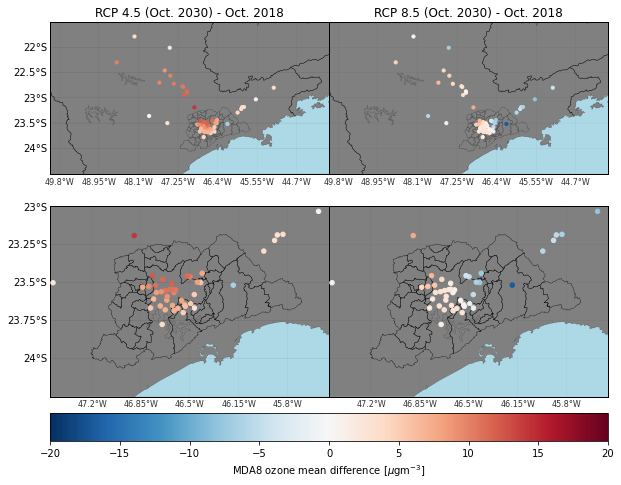

In [20]:
diff = {'RCP 4.5 (Oct. 2030) - Oct. 2018':o3_mean.o3_rcp45.values - o3_mean.o3.values,
        'RCP 8.5 (Oct. 2030) - Oct. 2018':o3_mean.o3_rcp85.values - o3_mean.o3.values}

min_v = -20
max_v = 20
fig, ax = plt.subplots(2,2, figsize=(10,10),gridspec_kw={'hspace':0.0,'wspace':0})
res = 'h'
for i, d in enumerate(diff):
    m = Basemap(projection='merc',llcrnrlon=-50,llcrnrlat=-24.5,
                urcrnrlon=-44,urcrnrlat=-21.5, resolution=res, ax=ax[0,i])
    m.drawcoastlines(color='0.2',linewidth=0.2)
    m.drawstates(color='k',linewidth=0.5)
    m.drawmapboundary(fill_color='lightblue')
    if i ==0:
        m.drawparallels(np.arange(-60, 0, 0.5),linewidth=0.05,labels=[1,0,0,0])
    m.drawparallels(np.arange(-60, 0, 0.5),linewidth=0.05,labels=[0,0,0,0], fontsize=8, alpha=0.8)
    m.drawmeridians(np.arange(-60, 0, 0.85),linewidth=0.05, labels=[0,0,0,1], fontsize=8, alpha=0.8)
    m.fillcontinents(color='0.5',lake_color='0.5')
    m.readshapefile("../3_Modeling/MunRM07",'sp', drawbounds=True, color='0.3',
                default_encoding='ISO-8859-1',linewidth=0.3)

    cb = m.scatter(o3_mean.lon.values, o3_mean.lat.values, marker='o',vmin=min_v,vmax=max_v,
          latlon=True,c=diff[d], cmap='RdBu_r', alpha=1, s = 10,zorder=100)
    ax[0,i].set_title(d)
    
    m = Basemap(projection='merc',llcrnrlon=-47.5,llcrnrlat=-24.25,
                urcrnrlon=-45.5,urcrnrlat=-23, resolution=res, ax=ax[1,i])
    m.drawcoastlines(color='0.2',linewidth=0.2)
    m.drawstates(color='k',linewidth=0.5)
    m.drawmapboundary(fill_color='lightblue')
    if i ==0:
        m.drawparallels(np.arange(-60, 0, 0.25),linewidth=0.05,labels=[1,0,0,0])
    m.drawparallels(np.arange(-50, 0, 0.25),linewidth=0.05,labels=[0,0,0,0], fontsize=8, alpha=0.8)
    m.drawmeridians(np.arange(-50, 0, 0.35),linewidth=0.05, labels=[0,0,0,1], fontsize=8, alpha=0.8)
    m.fillcontinents(color='0.5',lake_color='0.5')
    m.readshapefile("../3_Modeling/MunRM07",'sp', drawbounds=True, 
                default_encoding='ISO-8859-1',linewidth=0.3)

    cb = m.scatter(o3_mean.lon.values, o3_mean.lat.values, marker='o',vmin=min_v,vmax=max_v,
          latlon=True,c=diff[d], cmap='RdBu_r', alpha=1, s = 20,zorder=100)    
    
fig.colorbar(cb,label='MDA8 ozone mean difference [$\mu$gm$^{-3}$]',orientation='horizontal',ax=ax,pad=0.03)
fig.savefig('../4_Draft_Report/Dissertation/fig/MDA8_spatial_station_oct.pdf',bbox_inches='tight', facecolor='w')
